In [2]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import sklearn
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings
import sys
from importlib import reload
import matplotlib.ticker

warnings.filterwarnings('ignore')

In [3]:
sys.path.append("../../src")

In [4]:
import main
import vis

In [5]:
reload(vis)

<module 'vis' from '/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py'>

## AWS Data

In [6]:
temp = pd.read_csv('../../data/raw_data/ta_vp_rh_60_min_2022_09_01_2024_08_31_gap_filled_new.csv')
temp['datetime']=pd.to_datetime(temp['datetime'])
temp['datetime_UTC'] = temp['datetime']
temp['value'] = temp['ta']
temp = temp[temp['type'] == 'measured']

temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')
temp.index = temp.index.str[2:]

In [7]:
hin =pd.read_csv('../../data/processed_data/2_year_heat_island_dates_night.csv')

In [8]:
radius = 300
var = 'BuAre_sum'
time = hin.values.flatten()

In [51]:
# for all hours
radius = 300
var = 'BuAre_sum'
time = temp.columns.values

In [52]:
def multiple_scales(vars):

    radii = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500,600,750,1000,1250,1500,1750,2000]
    mean_stats = {}
    std_stats = {}
    spearman_stats = {}
    p_value_stats = {}
    pearson_stats = {}
    rmse_stats = {}
    cooks_stats = {}
    mi_stats = {}
    
    for radius in radii:
        mean_stats[radius] = {}
        std_stats[radius] = {}
        spearman_stats[radius] = {}
        p_value_stats[radius] = {}
        pearson_stats[radius] = {}
        rmse_stats[radius] = {}
        cooks_stats[radius] = {}
        mi_stats[radius] = {}
        
        for var in vars:
            data, mean, std, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, mi, y_pred = vis.stats_multiple_times(radius, var, time, temp)
            mean_stats[radius][var] = mean
            std_stats[radius][var] = std
            spearman_stats[radius][var] = spearman_corr
            p_value_stats[radius][var] = p_value
            pearson_stats[radius][var] = pearson_corr
            rmse_stats[radius][var] = rmse
            cooks_stats[radius][var] = cooks_d
            mi_stats[radius][var] = mi
            
    return mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats

In [53]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode','StrClo400_median']

In [54]:
mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats = multiple_scales(params)

In [55]:
mean_stats = pd.DataFrame(mean_stats).T
std_stats = pd.DataFrame(std_stats).T
spearman_stats = pd.DataFrame(spearman_stats).T
p_value_stats = pd.DataFrame(p_value_stats).T
pearson_stats = pd.DataFrame(pearson_stats).T
rmse_stats = pd.DataFrame(rmse_stats).T
cooks_stats = pd.DataFrame(cooks_stats).T
mi_stats = pd.DataFrame(mi_stats).T

In [56]:
spearman_stats = spearman_stats.apply(lambda x: abs(x))

In [57]:
mean_stats = mean_stats.apply(lambda x: abs(x))

In [58]:
mean_stats['BuAre_sum'] = mean_stats['BuAre_sum'] / mean_stats.index**2*np.pi
std_stats['BuAre_sum'] = std_stats['BuAre_sum'] / std_stats.index**2*np.pi
mean_stats['BuEWA_3D_sum'] = mean_stats['BuEWA_3D_sum'] / (mean_stats.index**2*np.pi)
std_stats['BuEWA_3D_sum'] = std_stats['BuEWA_3D_sum'] / (std_stats.index**2*np.pi)
mean_stats["BuVol_3D_sum"] = mean_stats["BuVol_3D_sum"] / (mean_stats.index**2*np.pi)
std_stats["BuVol_3D_sum"] = std_stats["BuVol_3D_sum"] / (std_stats.index**2*np.pi)

In [59]:
# standardise columns ending in _mean between 0 and 1
def standardize_column(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

In [60]:
for col in mean_stats.columns:
    mean_stats = standardize_column(mean_stats, col)

In [61]:
for col in std_stats.columns:
    std_stats = standardize_column(std_stats, col)

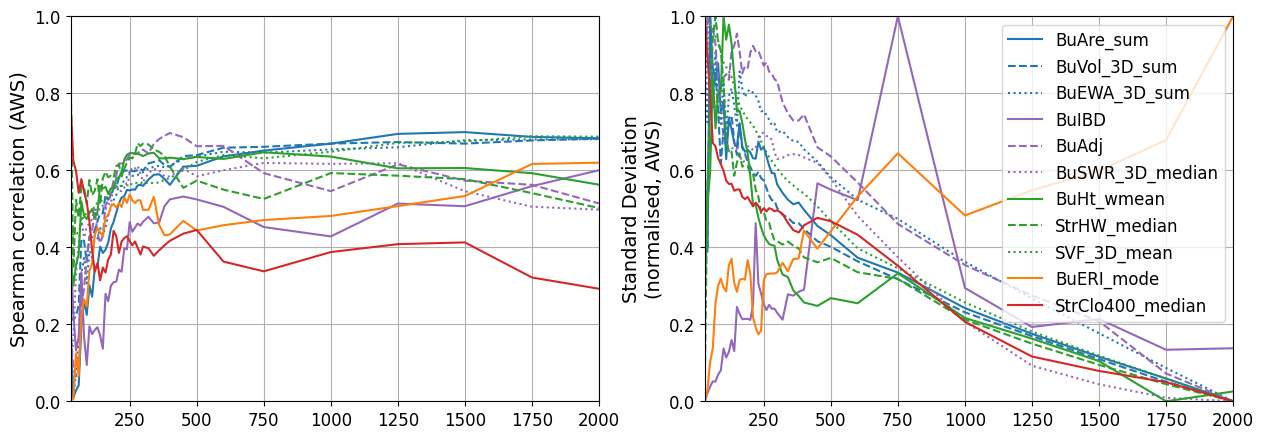

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_mode': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuERI_mode': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    axs[0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0].set_ylabel('Spearman correlation (AWS)', fontsize=14)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid()

for param in params:
    axs[1].plot(std_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1].set_ylabel("Standard Deviation\n(normalised, AWS)", fontsize=14)
axs[1].legend(prop={'size': 12})
axs[1].set_ylim(0, 1)
axs[1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid()

plt.savefig('../../figures/fig9/aws_2_year.png', dpi=300, bbox_inches='tight')
plt.savefig('../../figures/fig9/aws_2_year.svg', dpi=300, bbox_inches='tight')

In [62]:
# combine mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats into one dataframe and add name to end of each column
combined_stats = pd.DataFrame()

for dtf, name in zip([mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats],
                    ['mean', 'std', 'spearman', 'p_value', 'pearson', 'rmse', 'cooks', 'mi']):
    df_renamed = dtf.add_suffix(f'_{name}')
    combined_stats = pd.concat([combined_stats, df_renamed], axis=1)

In [63]:
#combined_stats.to_csv('/Users/lisawink/Documents/paper1/data/processed_data/aws_2_year_multiple_scale_stats.csv') #HIN ONLY
combined_stats.to_csv('../../data/processed_data/aws_2_year_multiple_scale_stats_ALL_YEAR.csv')

In [38]:
# for every p value greater than  0.05, make spearman correlation value nan in each row of the df
for i in params:
    # If the p-value column is greater than 0.05, set the correlation column to NaN
    combined_stats.loc[combined_stats[i+'_p_value'] > 0.05, i+'_spearman'] = np.nan

## AWS Data

In [13]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode','StrClo400_median']

In [20]:
combined_stats = pd.read_csv('../../paper1/data/processed_data/aws_2_year_multiple_scale_stats.csv', index_col=0) #HIN ONLY

In [21]:
combined_stats

,BuAre_sum_mean,BuVol_3D_sum_mean,BuEWA_3D_sum_mean,BuIBD_mean,BuAdj_mean,BuSWR_3D_median_mean,BuHt_wmean_mean,StrHW_median_mean,SVF_3D_mean_mean,BuERI_mode_mean,...,BuVol_3D_sum_mi,BuEWA_3D_sum_mi,BuIBD_mi,BuAdj_mi,BuSWR_3D_median_mi,BuHt_wmean_mi,StrHW_median_mi,SVF_3D_mean_mi,BuERI_mode_mi,StrClo400_median_mi
30,0.943769,0.809879,1.000000,0.000000,1.000000,0.000000,0.593905,1.000000,0.006506,1.000000,...,0.629502,0.632833,0.485230,0.405256,0.597146,0.615963,0.622686,0.659717,0.591298,0.816676
40,0.805411,0.738248,0.809548,0.089025,0.774907,0.773413,0.681589,0.632037,0.000000,0.948213,...,0.566203,0.538436,0.632714,0.316714,0.523861,0.589538,0.651541,0.624051,0.587078,0.790986
50,0.964084,0.986405,0.865861,0.238341,0.544200,0.731969,0.800955,0.641549,0.010010,0.888546,...,0.603331,0.595728,0.528421,0.419536,0.593930,0.641374,0.606093,0.609469,0.586899,0.782584
60,1.000000,1.000000,0.861617,0.257518,0.495002,1.000000,1.000000,0.724458,0.022965,0.846860,...,0.555562,0.576687,0.650407,0.467597,0.601953,0.630363,0.646503,0.658742,0.593287,0.651009
70,0.945423,0.956751,0.862304,0.290617,0.395060,0.343692,0.789576,0.789404,0.022587,0.761998,...,0.617597,0.585151,0.631419,0.530418,0.631509,0.658094,0.686765,0.634793,0.628871,0.693270
80,0.869043,0.886637,0.749832,0.375053,0.303662,0.632055,0.561140,0.574024,0.018469,0.715697,...,0.593381,0.599765,0.558487,0.538096,0.604150,0.633584,0.629523,0.608580,0.603306,0.624622
90,0.736170,0.758449,0.667808,0.423240,0.309563,0.920591,0.551481,0.557426,0.027292,0.670840,...,0.557451,0.609143,0.628259,0.527510,0.608004,0.605926,0.595514,0.664790,0.613860,0.634339
100,0.783171,0.876688,0.712143,0.504933,0.256693,0.377602,0.641551,0.471339,0.041675,0.643804,...,0.548782,0.562576,0.606254,0.537868,0.539619,0.607748,0.623725,0.618534,0.588247,0.609685
110,0.717817,0.827100,0.663261,0.488616,0.183792,0.585002,0.680165,0.419605,0.042853,0.630632,...,0.553636,0.577745,0.547878,0.565089,0.574539,0.593454,0.675136,0.668110,0.604375,0.594426
120,0.645202,0.758586,0.591724,0.550132,0.117636,0.198115,0.497001,0.366997,0.040639,0.623873,...,0.570844,0.638049,0.548124,0.583272,0.559287,0.592836,0.643770,0.629608,0.625533,0.575851


## Meteobike Data

In [9]:
df = pd.read_csv('../../data/processed_data/mbike/270623_stats_scales.csv', index_col=0)

In [10]:
df['BuAre_sum_mean'] = df['BuAre_sum_mean'] / df.index**2*np.pi
df['BuAre_sum_std'] = df['BuAre_sum_std'] / df.index**2*np.pi
df['BuEWA_3D_sum_mean'] = df['BuEWA_3D_sum_mean'] / (df.index**2*np.pi)
df['BuEWA_3D_sum_std'] = df['BuEWA_3D_sum_std'] / (df.index**2*np.pi)
df["BuVol_3D_sum_mean"] = df["BuVol_3D_sum_mean"] / (df.index**2*np.pi)
df["BuVol_3D_sum_std"] = df["BuVol_3D_sum_std"] / (df.index**2*np.pi)

In [11]:
# standardise columns ending in _mean between 0 and 1
def standardize_column(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

for col in df.columns:
    if col.endswith('_mean'):
        df = standardize_column(df, col)
    if col.endswith('_std'):
        df = standardize_column(df, col)

In [15]:
# for every p value greater than  0.05, make spearman correlation value nan in each row of the df

for i in params:
    # If the p-value column is greater than 0.05, set the correlation column to NaN
    df.loc[df[i + '_spearman_p_value'] > 0.05, i + '_spearman_corr'] = np.nan

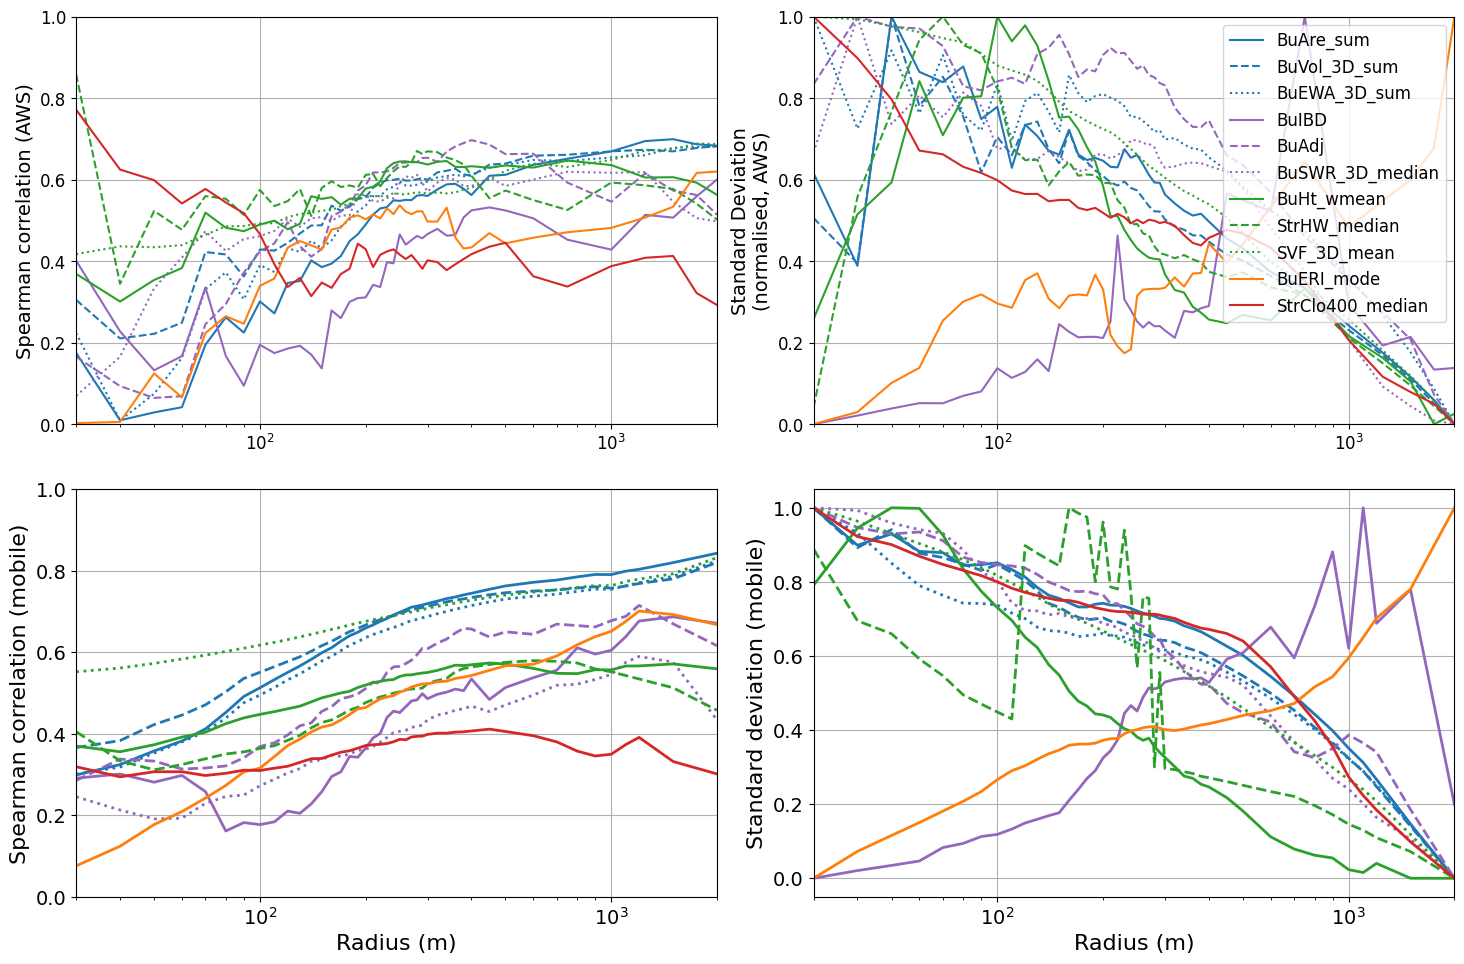

In [22]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_mode': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuERI_mode': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

axs[0,0].set_xscale('log')
for param in params:
    axs[0,0].plot(combined_stats[param+'_spearman'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0,0].set_ylabel('Spearman correlation (AWS)', fontsize=14)
axs[0,0].set_ylim(0, 1)
axs[0,0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].grid()

axs[0,1].set_xscale('log')
for param in params:
    axs[0,1].plot(combined_stats[param+'_std'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0,1].set_ylabel("Standard Deviation\n(normalised, AWS)", fontsize=14)
axs[0,1].legend(prop={'size': 12})
axs[0,1].set_ylim(0, 1)
axs[0,1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].grid()

axs[1,0].set_xscale('log')
for param in params:
    axs[1,0].plot(abs(df[param+'_spearman_corr']), label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[1,0].set_ylabel('Spearman correlation (mobile)', fontsize=16)
axs[1,0].set_ylim(0, 1)
axs[1,0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[1,0].tick_params(axis='both', which='major', labelsize=14)
axs[1,0].grid()
axs[1,0].set_xlabel('Radius (m)', fontsize=16)

axs[1,1].set_xscale('log')
for param in params:
    axs[1,1].plot(df[param+'_std'], label=param, linestyle=linestyle_mapping[param],linewidth=2, color=color_mapping[param])
axs[1,1].set_ylabel('Standard deviation (mobile)', fontsize=16)
axs[1,1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1,1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1,1].tick_params(axis='both', which='major', labelsize=14)
axs[1,1].set_xlabel('Radius (m)', fontsize=16)
#axs[1,1].legend(prop={'size': 14}, bbox_to_anchor=(1.05, 0.85), loc='upper left')


plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('../../figures/fig7/comb.png')
plt.savefig('../../figures/fig7/comb.pdf')
plt.show()

In [36]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode','StrClo400_median']

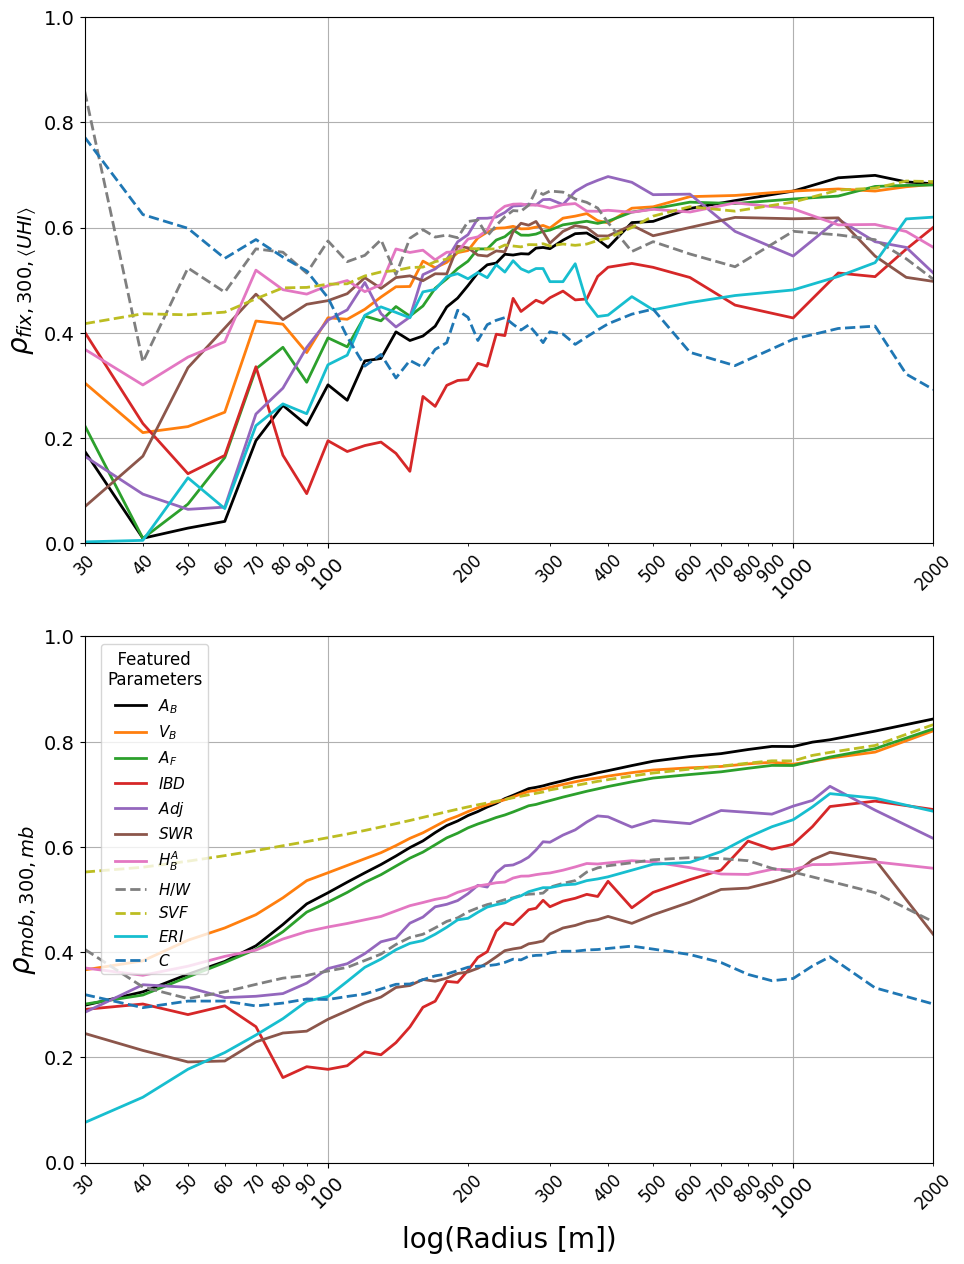

In [26]:
fig, axs = plt.subplots(2,1, figsize=(10,13))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '-',
    'BuEWA_3D_sum': '-',
    'BuIBD':'-',
    'BuAdj':'-',
    'BuSWR_3D_median':'-',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': '--',
    'BuERI_mode': '-',
    'StrClo400_median': '--'
}

color_mapping = {
    'BuAre_sum': 'black',
    'BuVol_3D_sum': 'tab:orange',
    'BuEWA_3D_sum': 'tab:green',
    'BuIBD':'tab:red',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:brown',
    'BuHt_wmean': 'tab:pink',
    'StrHW_median': 'tab:gray',
    'SVF_3D_mean': 'tab:olive',
    'BuERI_mode': 'tab:cyan',
    'StrClo400_median': 'tab:blue'
}

axs[0].set_xscale('log')
for param in params:
    axs[0].plot(combined_stats[param+'_spearman'], label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[0].set_ylabel(r"$\rho_{fix,300,〈UHI〉}$", fontsize=20)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].grid()
axs[0].tick_params(axis='x', which='minor', rotation=45,labelsize=12)
axs[0].tick_params(axis='x', labelrotation=45)


axs[1].set_xscale('log')
for param in params:
    axs[1].plot(abs(df[param+'_spearman_corr']), label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[1].set_ylabel(r"$\rho_{mob,300,mb}$", fontsize=20)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(30, 2000)

axs[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid()
axs[1].set_xlabel('log(Radius [m])', fontsize=20)
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].tick_params(axis='x', which='minor', rotation=45,labelsize=12)
axs[1].legend(['$\it{A_B}$','$\it{V_B}$','$\it{A_F}$','$\it{IBD}$', '$\it{Adj}$', '$\it{SWR}$', '$\it{H_B^A}$', '$\it{H/W}$', '$\it{SVF}$', '$\it{ERI}$', '$\it{C}$'],prop={'size': 11}, bbox_to_anchor=(0.01, 1), loc='upper left', title='  Featured\nParameters', title_fontsize=12)



plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('../../figures/fig7/spear_new.png',dpi=300, bbox_inches='tight')
plt.savefig('../../figures/fig7/spear_new.pdf')
plt.savefig('../../figures/fig7/spear_new.svg')
plt.show()

# FOR ALL HOURS
from '/aws_2_year_multiple_scale_stats_ALL_YEAR.csv'

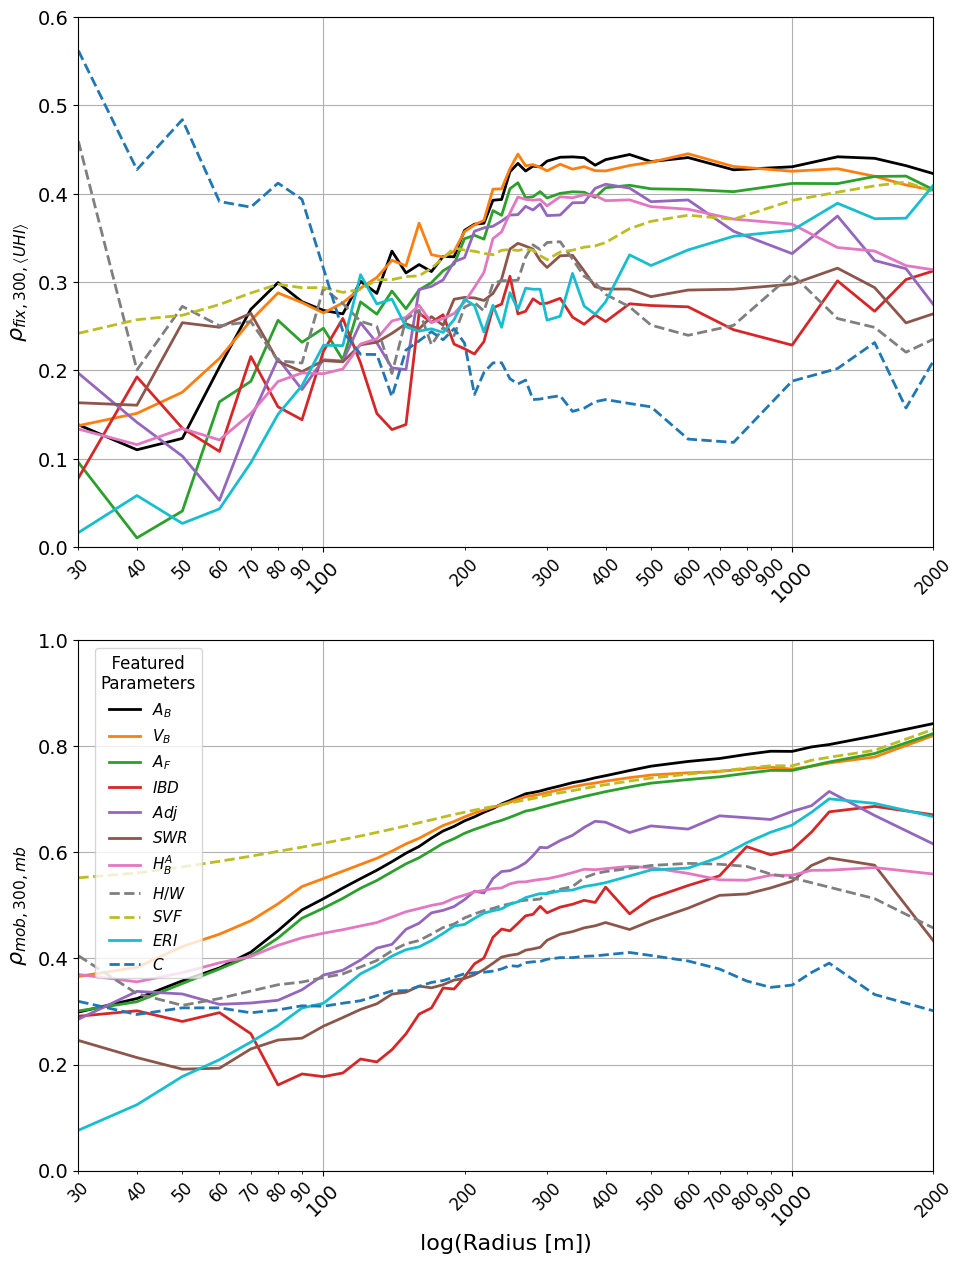

In [71]:
fig, axs = plt.subplots(2,1, figsize=(10,13))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '-',
    'BuEWA_3D_sum': '-',
    'BuIBD':'-',
    'BuAdj':'-',
    'BuSWR_3D_median':'-',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': '--',
    'BuERI_mode': '-',
    'StrClo400_median': '--'
}

color_mapping = {
    'BuAre_sum': 'black',
    'BuVol_3D_sum': 'tab:orange',
    'BuEWA_3D_sum': 'tab:green',
    'BuIBD':'tab:red',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:brown',
    'BuHt_wmean': 'tab:pink',
    'StrHW_median': 'tab:gray',
    'SVF_3D_mean': 'tab:olive',
    'BuERI_mode': 'tab:cyan',
    'StrClo400_median': 'tab:blue'
}

axs[0].set_xscale('log')
for param in params:
    axs[0].plot(combined_stats[param+'_spearman'], label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[0].set_ylabel(r"$\rho_{fix,300,〈UHI〉}$", fontsize=16)
axs[0].set_ylim(0, 0.6)
axs[0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].grid()
axs[0].tick_params(axis='x', which='minor', rotation=45,labelsize=12)
axs[0].tick_params(axis='x', labelrotation=45)


axs[1].set_xscale('log')
for param in params:
    axs[1].plot(abs(df[param+'_spearman_corr']), label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[1].set_ylabel(r"$\rho_{mob,300,mb}$", fontsize=16)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(30, 2000)

axs[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid()
axs[1].set_xlabel('log(Radius [m])', fontsize=16)
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].tick_params(axis='x', which='minor', rotation=45,labelsize=12)
axs[1].legend(['$\it{A_B}$','$\it{V_B}$','$\it{A_F}$','$\it{IBD}$', '$\it{Adj}$', '$\it{SWR}$', '$\it{H_B^A}$', '$\it{H/W}$', '$\it{SVF}$', '$\it{ERI}$', '$\it{C}$'],prop={'size': 11}, bbox_to_anchor=(0.01, 1), loc='upper left', title='  Featured\nParameters', title_fontsize=12)



plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('../../fig7/spear_new_all_year.png')
plt.savefig('../../fig7/spear_new_all_year.pdf')
plt.savefig('../../fig7/spear_new_all_year.svg')
plt.show()

## Supplementary Plots

In [74]:
combined_stats1 = pd.read_csv('../../data/processed_data/aws_2_year_multiple_scale_stats.csv',index_col = 0) #HIN ONLY

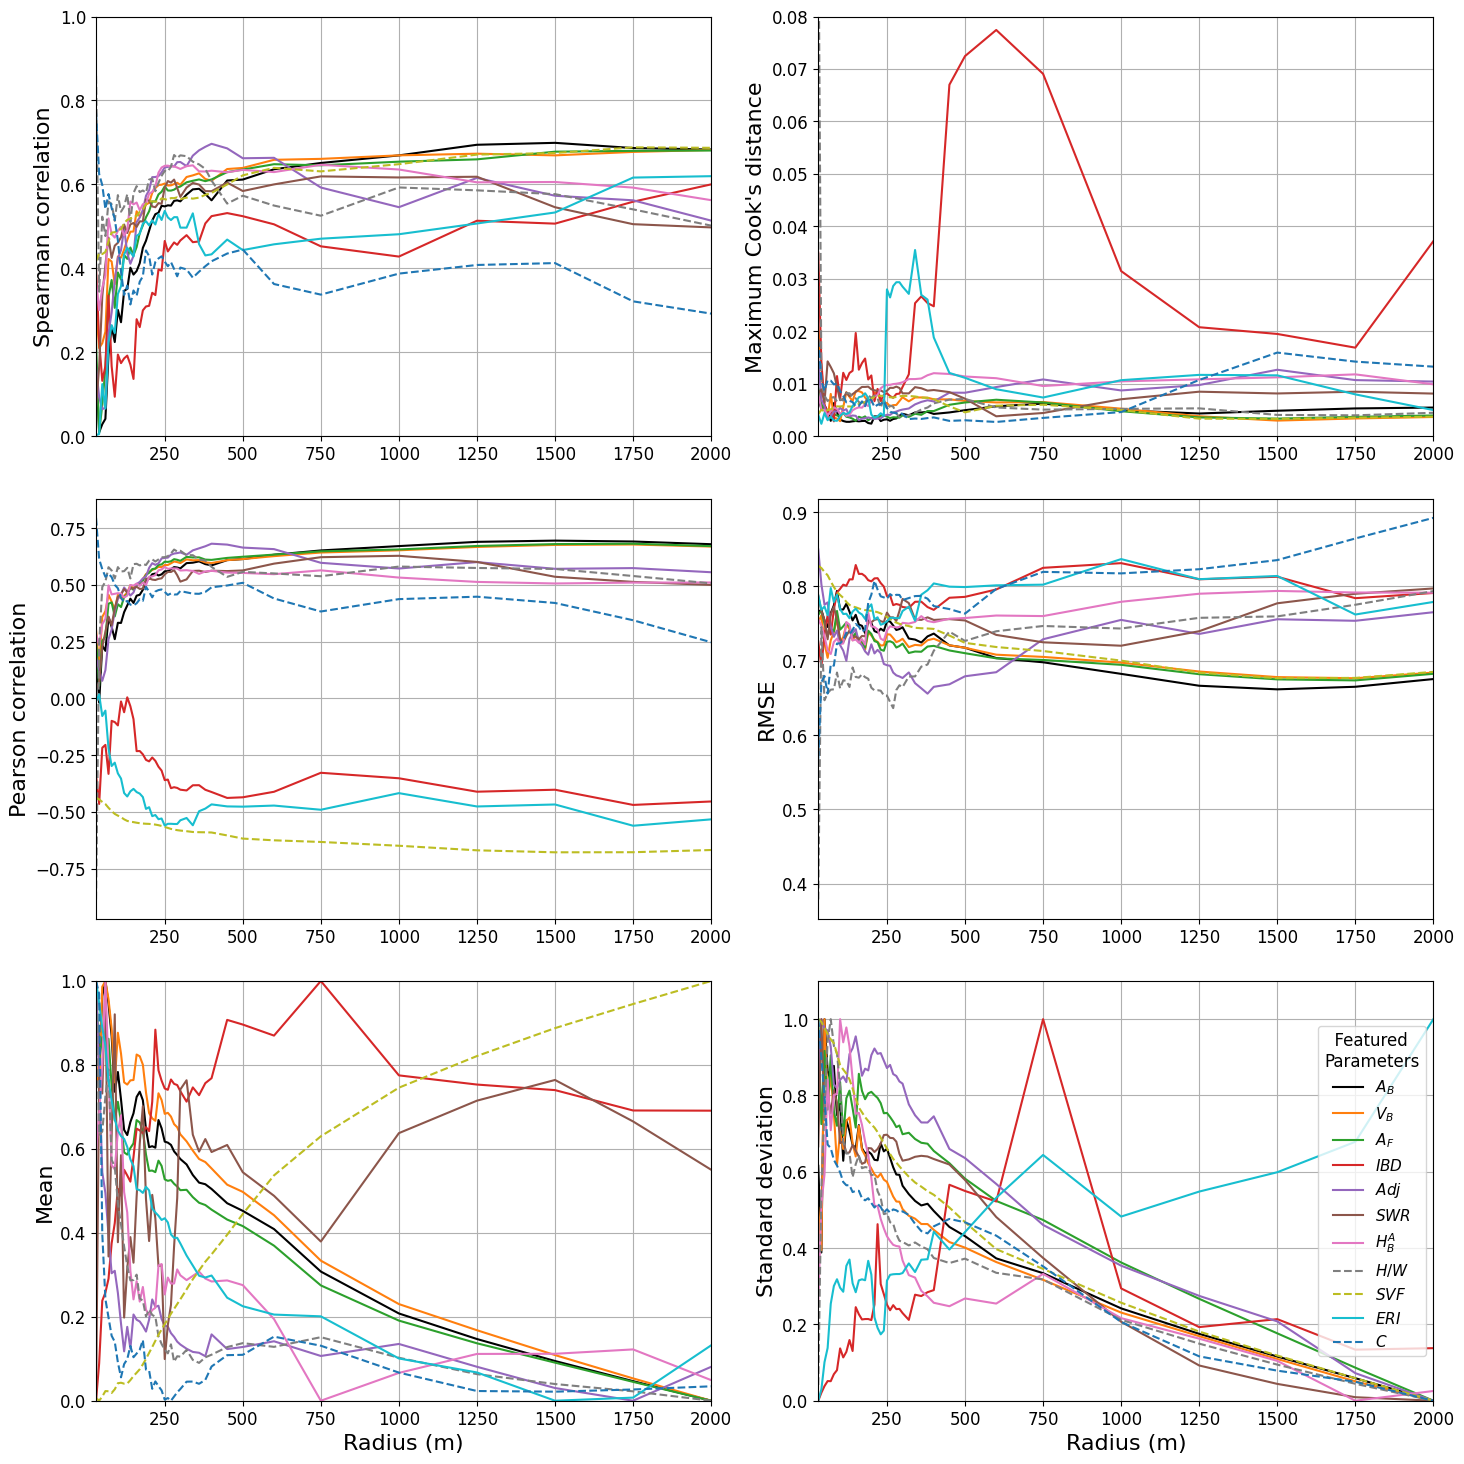

In [107]:
# make 4 subplots
fig, axs = plt.subplots(3,2, figsize=(15, 15))

for param in params:
    axs[0, 0].plot(combined_stats1[param+'_spearman'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=12)
axs[0, 0].grid()

for param in params:
    axs[0, 1].plot(combined_stats1[param+'_cooks'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 1].set_ylabel("Maximum Cook's distance", fontsize=16)
axs[0, 1].set_ylim(0, 0.08)
axs[0, 1].set_xlim(30, 2000)
axs[0, 1].tick_params(axis='both', which='major', labelsize=12)
axs[0, 1].grid()

for param in params:
    axs[1, 0].plot(combined_stats1[param+'_pearson'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=16)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=12)
axs[1, 0].grid()

for param in params:
    axs[1, 1].plot(combined_stats1[param+'_rmse'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 1].set_ylabel('RMSE', fontsize=16)
axs[1, 1].grid()
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=12)


for param in params:
    axs[2, 0].plot(combined_stats1[param+'_mean'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[2, 0].set_ylabel("Mean", fontsize=16)
axs[2, 0].set_ylim(0, 1)
axs[2, 0].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=12)
axs[2, 0].grid()

for param in params:
    axs[2, 1].plot(combined_stats1[param+'_std'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[2, 1].set_ylabel("Standard deviation", fontsize=16)
axs[2, 1].set_ylim(0, 1.1)
axs[2, 1].set_xlim(30, 2000)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=12)
axs[2, 1].grid()
axs[2, 1].legend(['$\it{A_B}$','$\it{V_B}$','$\it{A_F}$','$\it{IBD}$', '$\it{Adj}$', '$\it{SWR}$', '$\it{H_B^A}$', '$\it{H/W}$', '$\it{SVF}$', '$\it{ERI}$', '$\it{C}$'],prop={'size': 11}, bbox_to_anchor=(1, 0.5), loc='right', title='  Featured\nParameters', title_fontsize=12)


plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('../../figures/fig7/all_stats_hin.png',dpi=300, bbox_inches='tight')
plt.show()

## Meteobike Supplementary Plot

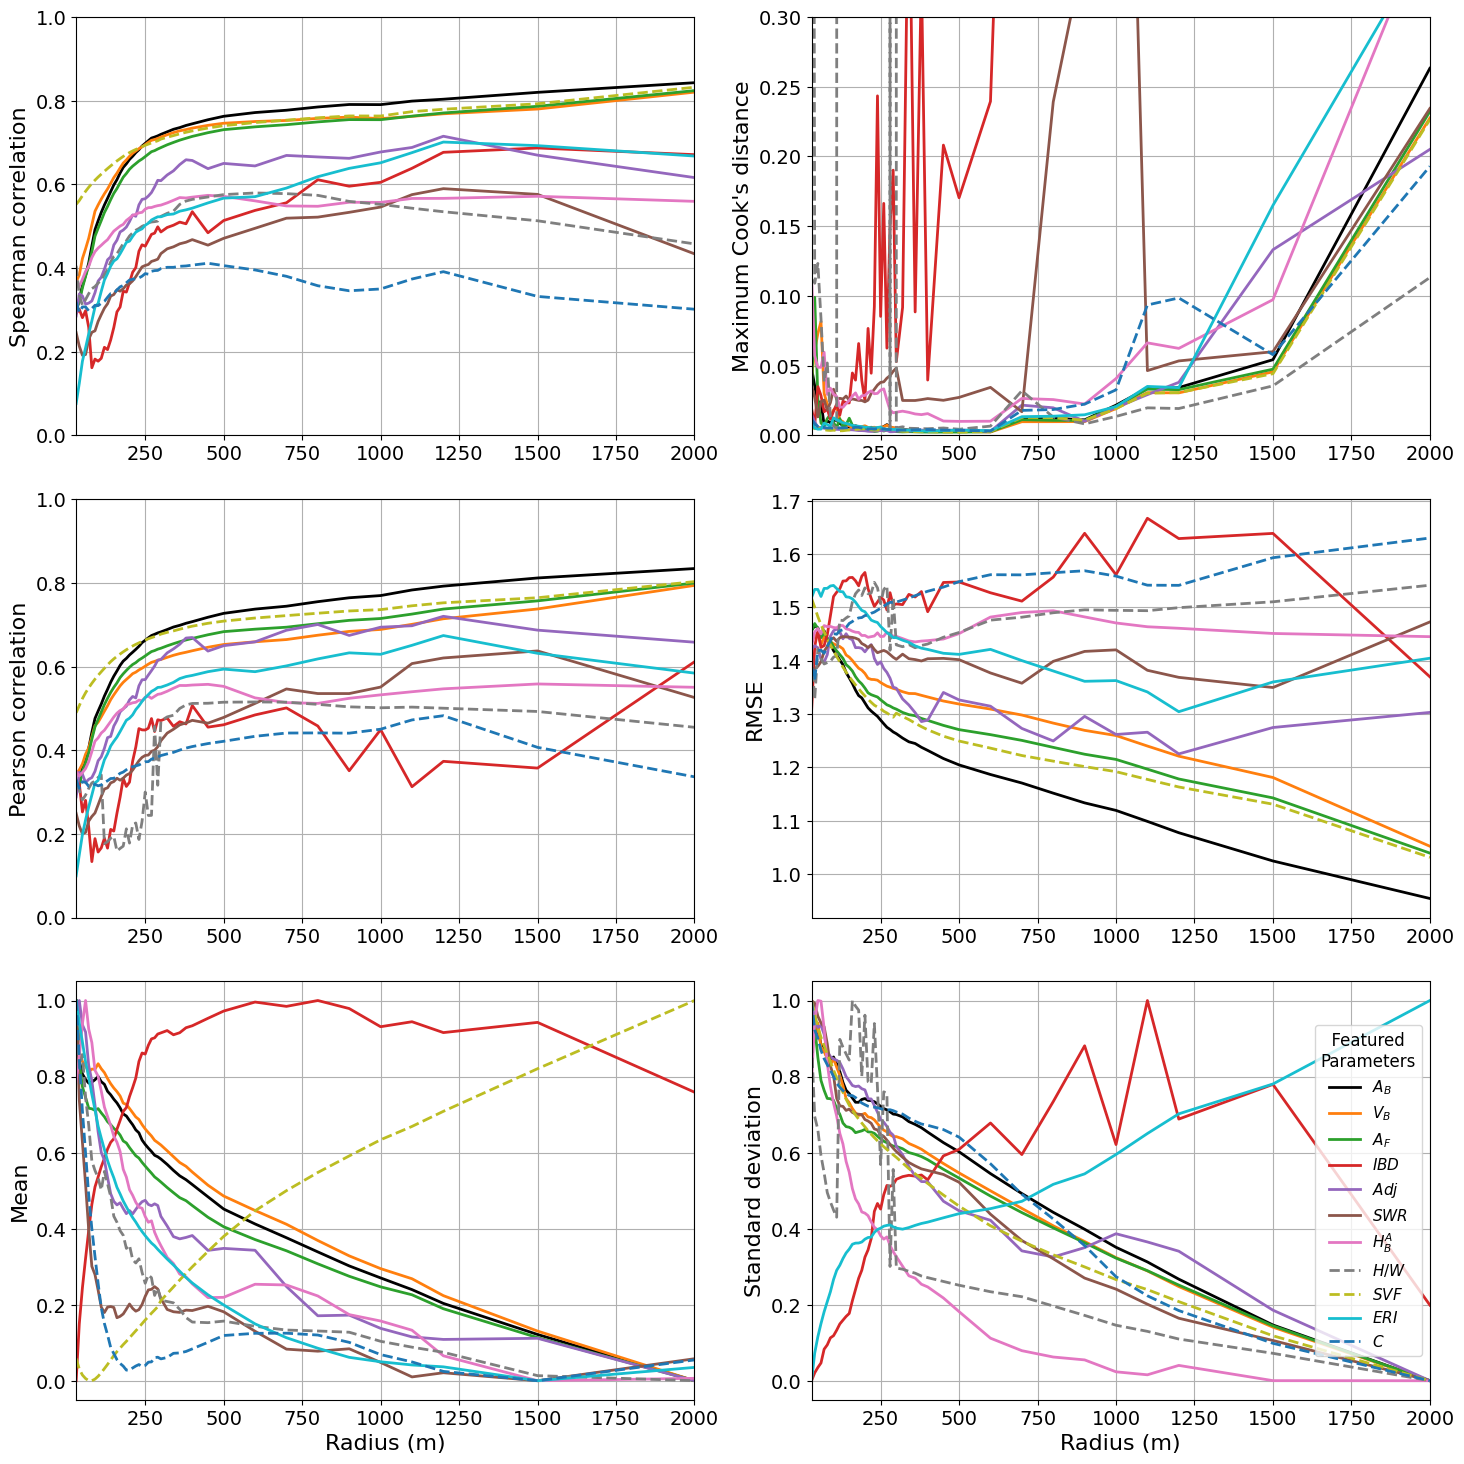

In [106]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))

for var in params:
    axs[0, 0].plot(abs(df[var+'_spearman_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for var in params:
    axs[0, 1].plot(df[var+'_cooks_d'], label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 1].set_ylabel("Maximum Cook's distance", fontsize=16)
axs[0, 1].set_ylim(0, 0.3)
axs[0, 1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for var in params:
    axs[1, 0].plot(abs(df[var+'_pearson_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2,color=color_mapping[var])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for var in params:
    axs[1, 1].plot(df[var+'_rmse'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[1, 1].set_ylabel('RMSE', fontsize=16)
axs[1, 1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

for var in params:
    axs[2, 0].plot(df[var+'_mean'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 0].set_ylabel("Mean", fontsize=16)
#axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].set_xlim(30, 2000)
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)
axs[2, 0].grid()

for var in params:
    axs[2, 1].plot(df[var+'_std'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 1].set_ylabel("Standard deviation", fontsize=16)
#axs[2, 1].set_ylim(0, 2)
axs[2, 1].set_xlim(30, 2000)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)
axs[2, 1].grid()
axs[2, 1].legend(['$\it{A_B}$','$\it{V_B}$','$\it{A_F}$','$\it{IBD}$', '$\it{Adj}$', '$\it{SWR}$', '$\it{H_B^A}$', '$\it{H/W}$', '$\it{SVF}$', '$\it{ERI}$', '$\it{C}$'],prop={'size': 11}, bbox_to_anchor=(1, 0.5), loc='right', title='  Featured\nParameters', title_fontsize=12)


plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('../../figures/fig7/mbike270623_param_scale_plot_featured_list.png')
plt.savefig('../../figures/fig7/mbike270623_param_scale_plot_featured_list.pdf')
plt.show()